<div class="alert alert-info">
<h1><center><font color=darkblue> Comparing Resampling Techniques to Handle the Class Imbalance Problem: A credit card Fraud Prediction Case Study.<font></left></h1>


</div> 

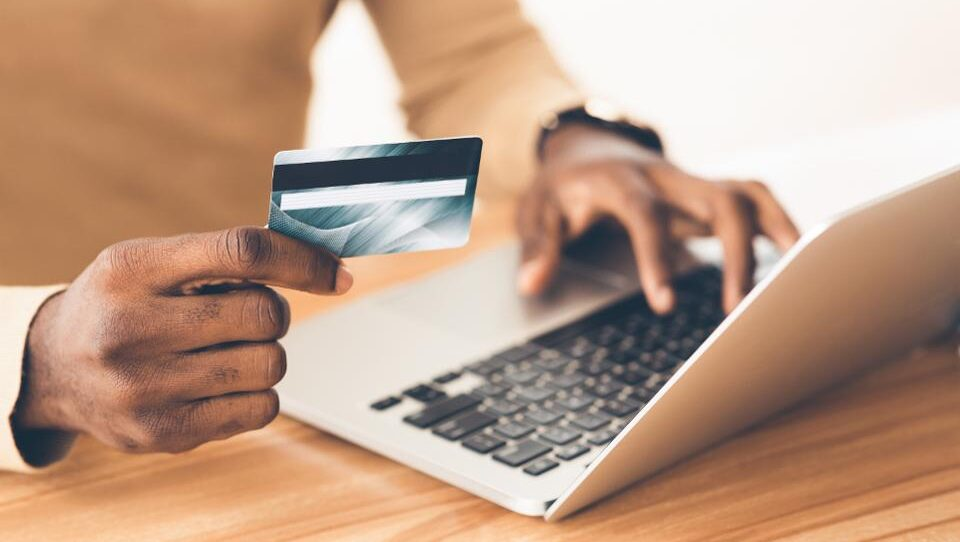

# <font color=RoyalBlue>1. Introduction<font>

### <font color=CornflowerBlue>Objectives:<font>

In this project, I am going to use the *Credit-card-Fraud Detection-Imbalanced-Dataset*.  The dataset is publically available on the Kaggle.  The classification goal is to predict whether the credit card user commited fraud or not. The dataset provides the patients’ information. It includes over 5,000 records and 12 attributes. The data contains 25000 observations with 20 attributes.

 The dataset contains 20 independent features and 1 target feature as described below.<br/>
> 1. ID
> 2. gender 
> 3. Car (2 values) 
> 4. Reality (2 Values)
> 5. No_of_child (2 values)
> 6. Income (4 values) 
> 7. Income Type (values 0,1)
> 8. Education Type 
> 9. Family Type
> 10. House_type
> 11. Flag_mobil
> 12. Workphone
> 13. Phone
> 14. Email
> 15. Family Size
> 16. Begin month
> 17. Age
> 18. Years_Employed
> 19. Target - is the binary target variable, 0 indicates that the credit card user  stroke, the value is 1 if not.

# <font color=RoyalBlue>2. Exploratory Data Analysis<font>

### <font color=CornflowerBlue>2.1 Import Library:<font>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import plotly.express as ex

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
import pandas_profiling
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,roc_auc_score, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")




### <font color=CornflowerBlue>2.2 Data Preparation :<font>

In [ ]:
# Importing the data and checking the first five row of the data
credit_raw = pd.read_csv("../input/credit-card-dataset/credit_dataset.csv")
credit_raw.head()

In [ ]:
# Showing the last 5 rows of the data
credit_raw.tail()

In [ ]:
le = LabelEncoder()
credit_raw['GENDER'] = le.fit_transform(credit_raw['GENDER'])
credit_raw['CAR'] = le.fit_transform(credit_raw['CAR'])
credit_raw['REALITY'] = le.fit_transform(credit_raw['REALITY'])
credit_raw['INCOME_TYPE'] = le.fit_transform(credit_raw['INCOME_TYPE'])
credit_raw['EDUCATION_TYPE'] = le.fit_transform(credit_raw['EDUCATION_TYPE'])
credit_raw['FAMILY_TYPE'] = le.fit_transform(credit_raw['FAMILY_TYPE'])
credit_raw['HOUSE_TYPE'] = le.fit_transform(credit_raw['HOUSE_TYPE'])

In [ ]:
# checking the size of the raw dataset
credit_raw.size

In [ ]:
# Define a function to compress the memory size
def reduce_size(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
credit_raw = reduce_size(credit_raw)

### <font color=CornflowerBlue>2.3 Handling Missing Data:<font>

In [ ]:
# Profiling of Data
x=pandas_profiling.ProfileReport(credit_raw)
x

In [ ]:
# crosscheck the dataset to identify the feature with missing value
print(credit_raw.info())
missing_values = (credit_raw.isnull().sum() / len(credit_raw)) * 100
print("\nFeatures with missing values: \n", missing_values[missing_values > 0])

In [ ]:
# Checking for the features we have in the dataset to see if there are useless features
credit_raw.columns

In [ ]:
# Drop the Id colomn since it is the only feature that won't be needed for the data processing
credit_raw.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
credit_raw.drop('ID', inplace=True, axis=1)

In [ ]:
# Finding out the percentage of missing values 
# In order to know if we can ignore, fill or eliminate the missing values
count=0
for i in credit_raw.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('The percentage of missing value is',round((count/len(credit_raw.index))*100),'percent')

plt.title('Missing Value in Stroke Dataset',fontweight='bold')
ax = sns.heatmap(credit_raw.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()

In [ ]:
# print data characteristics, usings pandas built-in describe() function
credit_raw.describe()

#   <font color=RoyalBlue>3. Data Visualization <font>

In [ ]:
# Also, Calculate the percentage that committed fraud or not
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['darkturquoise', 'darkorange']
plt.style.use('default')
plt.rcParams['figure.figsize']=(12,6)

ax = sns.countplot(x='TARGET', data=credit_raw, palette=colors, alpha=0.9, edgecolor=('white'), linewidth=2)
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('target', fontsize=12)
ax.grid(b=True, which='major', color='grey', linewidth=0.2)
plt.title('The Fraud percentage', fontsize=18)
plt.show()

stroke_0 = len(credit_raw[credit_raw.TARGET == 0])
stroke_1 = len(credit_raw[credit_raw.TARGET == 1])
print("Percentage with no fraud: {:.2f}%".format((stroke_0 / (len(credit_raw.TARGET))*100)))
print("Percentage with fraud: {:.2f}%".format((stroke_1 / (len(credit_raw.TARGET))*100)))

In [ ]:
# Check Correlations
corr = credit_raw.corrwith(credit_raw['TARGET'],method='spearman').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(10)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlation of Variables with Class", fontsize=20)
plt.show()

In [ ]:
# checking correlation by plotting
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(credit_raw.corr(),annot=True,fmt='.1f')
plt.show()

In [ ]:
# More deeper correlation check
credit_raw.corr()

In [ ]:
credit_raw.drop('FLAG_MOBIL', inplace=True, axis=1)

In [ ]:
credit_scaled = credit_raw

In [ ]:
# Scaling all values except the target variable = target
from sklearn.preprocessing import MinMaxScaler
MMscal=MinMaxScaler()
features=['GENDER', 'CAR', 'REALITY', 'NO_OF_CHILD', 'INCOME',
       'INCOME_TYPE', 'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE',
       'WORK_PHONE', 'PHONE', 'E_MAIL',
       'FAMILY SIZE', 'BEGIN_MONTH', 'AGE','YEARS_EMPLOYED']
credit_scaled[features] = MMscal.fit_transform(credit_raw[features])

#Check first five rows after scaling
credit_scaled.head()

In [ ]:
# Creating Features and Target variable as X and Y
X = credit_scaled.drop('TARGET', axis=1)
Y = credit_scaled.TARGET

#   <font color=RoyalBlue>5. Modelling and Feature Importance <font>

In this section, I will be performing 5 major steps which are

- Modelling Using highly umbalanced credit Data
- Modelling Using Random Undersampled credit data 
- Modelling Using Balanced credit date (SMOTE)
- Modelling Using Balanced credit Data (SMOTETomek)
- Modelling using Balanced Credit Data (ADASyn)
These 5 Steps will be compared to pick the best algorithm that fit with the best Data

# <font color=Brown>5.1 Modelling Using highly umbalanced credit Data :<font>

## <font color=CornflowerBlue>5.1.1 Splitting the data into Train and Test :<font>

In [ ]:
# Splitting the data into training and testing data sets
from sklearn.model_selection import train_test_split
X_train1,X_test1,Y_train1,Y_test1=train_test_split(X,Y,test_size=0.2 ,random_state=1)

## <font color=CornflowerBlue>5.1.2 Collect Mutual Information :<font>

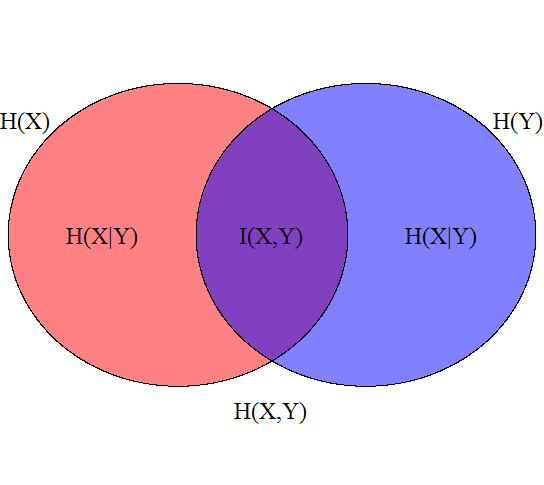Since we couldn't properly generate the best features for the training using correlation matrix, we will be using mutual information to generate the set of the best performing data for training. 

Hence, the mutual information (MI) of any two random variables is the measure of the mutual dependence between the two variables.

Frome the picture above, the violet area is the mutual information shared

In [ ]:
# Collecting Mutual Information for feature selection
from sklearn.feature_selection import mutual_info_regression
mutual_info1 = mutual_info_regression(X_train1, Y_train1)
mutual_info1 = pd.Series(mutual_info1)
mutual_info1.index = X_train1.columns
mutual_info1 = mutual_info1.sort_values(ascending=False)
mutual_info1

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns1 = list(mutual_info1[mutual_info1>0].index)
Req_Columns1

In [ ]:
# Checking the first 5 row of training data
X_train_final_1 = X_train1[Req_Columns1]
X_train_final_1.head(5)

In [ ]:
# Checking the last 3 rows of X test data
X_test_final_1 = X_test1[Req_Columns1]
X_test_final_1.head(5)

In [ ]:
# Check Stroke Proportion of the Imbalanced Data
fig = ex.pie(credit_scaled,names='TARGET')
fig.update_layout(title='<b>Imbalance fraud proportion<b>')
fig.show()

# <font color=CornflowerBlue>5.1.3 Run the Algorithms :<font>

In [ ]:
# First, Define the first evaluation function for the first batches of algorithms as 'evaluation_1'

def evaluation_1(Y_test1,Y_pred1):
    acc_1=accuracy_score(Y_test1,Y_pred1)
    rcl_1=recall_score(Y_test1,Y_pred1)
    f1_1=f1_score(Y_test1,Y_pred1)
    auc_score_1 = roc_auc_score(Y_test1,Y_pred1)
    prec_score_1=precision_score(Y_test1,Y_pred1)
    
    metric_dict={'accuracy': round(acc_1*100,2),
               'recall': round(rcl_1*100,2),
               'F1 score': round(f1_1*100,2),
               'auc score': round(auc_score_1*100,2),
               'precision': round(prec_score_1*100,2)
                }
    
    return print(metric_dict)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> I. Applying K-Nearest Neighbour on unbalanced Data </h4> 

In [ ]:
# Training KNN model 
np.random.seed(42) # Set the pseudo random number
KNC_model_1 =  KNeighborsClassifier() # Define the classifier

# Fit the model for prediction
KNC_model_1.fit(X_train_final_1,Y_train1)

# make prediction on testing data   
KNC_model_y_pred_1=KNC_model_1.predict(X_test_final_1) 
KNC_model_r2_score_1=round(r2_score(Y_test1,KNC_model_y_pred_1)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score_1)
print("Accuracy on Training set: ",round(KNC_model_1.score(X_train_final_1,Y_train1)*100,2))
KNC_model_score_1 = round(KNC_model_1.score(X_test_final_1,Y_test1)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_1)
evaluation_1(Y_test1,KNC_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test1,KNC_model_y_pred_1),annot=True,cbar=True)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> II. Applying Random Forest Classifier on unbalanced Data </h4> 

In [ ]:
# Training Random Forest model 
np.random.seed(42) # Set the pseudo random number
RFC_model_1=RandomForestClassifier() # Define the classifier

# Fit the model for prediction
RFC_model_1.fit(X_train_final_1,Y_train1)

# make prediction on testing data   
RFC_model_y_pred_1 = RFC_model_1.predict(X_test_final_1) 
RFC_model_r2_score_1=round(r2_score(Y_test1,RFC_model_y_pred_1)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score_1)
print("Accuracy on Training set: ",round(RFC_model_1.score(X_train_final_1,Y_train1)*100,2))
RFC_model_score_1 = round(RFC_model_1.score(X_test_final_1,Y_test1)*100,2)
print("Accuracy on Testing set: ",RFC_model_score_1)
evaluation_1(Y_test1,RFC_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test1,RFC_model_y_pred_1),annot=True,cbar=True)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> III. Applying Support Vector Machine on unbalanced Data </h4> 

In [ ]:
from sklearn.svm import SVC

# Training SVM model 
np.random.seed(42) # Set the pseudo random number
SVC_model_1=SVC() # Define the classifier

# Fit the model for prediction
SVC_model_1.fit(X_train_final_1,Y_train1)

# make prediction on testing data   
SVC_model_y_pred_1 = SVC_model_1.predict(X_test_final_1) 
SVC_model_r2_score_1=round(r2_score(Y_test1,SVC_model_y_pred_1)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",SVC_model_r2_score_1)
print("Accuracy on Training set: ",round(SVC_model_1.score(X_train_final_1,Y_train1)*100,2))
SVC_model_score_1 = round(SVC_model_1.score(X_test_final_1,Y_test1)*100,2)
print("Accuracy on Testing set: ",SVC_model_score_1)
evaluation_1(Y_test1,SVC_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test1,SVC_model_y_pred_1),annot=True,cbar=True)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> IV. Applying Multilayer Perceptron on unbalanced Data </h4> 

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define the classification parameters
mlp_1 = MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)
# Fit the models
mlp_1.fit(X_train_final_1, Y_train1)
mlp_pred_1= mlp_1.predict(X_test_final_1)

mlp_score_1 = mlp_1.score(X_train_final_1, Y_train1)
mlp_test_1 = mlp_1.score(X_test_final_1, Y_test1)
mlp_model_r2_score_1=round(r2_score(Y_test1,mlp_pred_1)*100,2)

# Make predictions
y_pred_1 =mlp_1.predict(X_test_final_1)

#evaluation
cm = confusion_matrix(Y_test1,y_pred_1)
print("R2 Score for predicted value: ",mlp_model_r2_score_1)
print('Training Score',mlp_score_1)
print('Testing Score \n',mlp_test_1)
print(cm)
evaluation_1(Y_test1,mlp_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test1,mlp_pred_1),annot=True,cbar=True)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> V. Applying Extreme Gradient Boost on unbalanced Data </h4> 

In [ ]:
np.random.seed(42) # Set the pseudo random number
from xgboost import XGBClassifier
XGB_model_1 = XGBClassifier()
XGB_model_1.fit(X_train_final_1,Y_train1)
XGB_model_y_pred_1=XGB_model_1.predict(X_test_final_1)
XGB_model_r2_score_1=round(r2_score(Y_test1,XGB_model_y_pred_1)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score_1)
print("Accuracy on Training set: ",round(XGB_model_1.score(X_train_final_1,Y_train1)*100,2))
XGB_model_score_1 = round(XGB_model_1.score(X_test_final_1,Y_test1)*100,2)
print("Accuracy on Testing set: ",XGB_model_score_1)
evaluation_1(Y_test1,XGB_model_y_pred_1)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test1,XGB_model_y_pred_1),annot=True,cbar=True)

# <font color=Purple>5.1.4 Extraction from the Algorithm Implementation :<font>

In [ ]:
# First Concatenate the accuracy scores
summary_score1 = pd.DataFrame({'Applied_Model': ['Random Forest Raw', 'K-Nearest Neighbour Raw', 'Support Vector Machine Raw', "Extreme Gradient Boost Raw", 'Multilayer Perceptron Raw'], 
                                'Accuracy_Score': [ RFC_model_score_1, KNC_model_score_1, SVC_model_score_1, XGB_model_score_1,mlp_test_1*100]})
summary_score1 = summary_score1.sort_values(by = ['Accuracy_Score'], ascending = False)
summary_score1

In [ ]:
# Define evaluation metrics for Support vector machine as the best performing algorithm
SVM_final_metrics1 ={'Accuracy': SVC_model_1.score(X_test_final_1,Y_test1),
                   'Precision': precision_score(Y_test1,SVC_model_y_pred_1),
                   'Recall': recall_score(Y_test1,SVC_model_y_pred_1),
                   'F1': f1_score(Y_test1,SVC_model_y_pred_1),
                   'AUC': roc_auc_score(Y_test1,SVC_model_y_pred_1)}

SVC_metrics=pd.DataFrame(SVM_final_metrics1,index=[0])
SVC_metrics.T.plot.bar(title='Best Metric Evaluation from Raw Data', color = 'black', legend=False);

As shown above, Support vector machine performed best of all the algorithms. Also, all the algorithms achieved a negative R2 score including our best performing SVM. Multilayer perceptron  has the least accuracy.

Let's talk about the Negative R2 scores:

Generally, 𝑅2 is computed as 1−𝑆𝑆res divided by 𝑆𝑆tot. (where the 𝑆𝑆𝑟𝑒𝑠 = residual error.)

What 𝑅2 does is that it basically compares the fit of the chosen model with that of a horizontal straight line (the null hypothesis). If the chosen model fits worse than a horizontal line, then 𝑅2 is negative

This means that most of the algorithms are fitting worse than the horizontal line. Which means the 𝑆𝑆res is greater than the 𝑆𝑆tot

Bottom line:
- The negative 𝑅2 is not mathematically impossible. It just means that the chosen model (with its constraints) fits the data really poorly.

So what can I do?
- I will investigate the model with the best AUC score and see if i can improve it in the next stage

- I will also see if handling of Imbalance Data can solve the issue of poorly fit

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> Investigating the best performing AUC (Random Forest) </h4> 

In [ ]:
# Find the Area under curve
from sklearn import metrics
y_pred_rfc_proba1 = RFC_model_1.predict_proba(X_test_final_1)[::,1]
fpr_rfc, tpr_rfc, _ = metrics.roc_curve(Y_test1,  y_pred_rfc_proba1)
auc_rfc = metrics.roc_auc_score(Y_test1, y_pred_rfc_proba1)
print("AUC RFC :", auc_rfc)

In [ ]:
# plot the ROC curve of the AUC
plt.plot(fpr_rfc,tpr_rfc,label="RFC, auc={:.3f})".format(auc_rfc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of Random Forest')
plt.legend(loc=4)
plt.show()

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:30px; color:Purple">Handling Imbalanced Dataset</h2>

# <font color=Brown>5.2 Modelling Using Random Undersampled Data :<font>

In [ ]:
# Define the dictionary for listing
accuracies_under = dict()
recall_under = dict()

In [ ]:
# Splitting the data into training and testing data sets
from sklearn.model_selection import train_test_split
X_train2,X_test2,Y_train2,Y_test2=train_test_split(X,Y,test_size=0.2 ,random_state=1)

In [ ]:
# Show the count of the target Before Applying Random UNDER Sampling

one_count = 0
zero_count = 0

for i in Y_train2:
    if i == 1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one count before applying RandomUnder Sampler is: ', one_count)
print('Number of zero count before applying RandomUnder Sampler is: ', zero_count)

In [ ]:
# Import the package and perform undersampling on the data 
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy= 0.6)

X_train2, Y_train2 = under.fit_resample(X_train2, Y_train2)

In [ ]:
#  Now, let us check the data After Applying Random UnderSampling
one_count = 0
zero_count = 0

for i in Y_train2:
    if i == 1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one count after applying RandomUnder Sampler is: ', one_count)
print('Number of zero count after applying RandomUnder Sampler is: ', zero_count)

In [ ]:
# plot to show target after Random Undersampling 
fig = ex.pie(Y_train2,names='TARGET')
fig.update_layout(title='<b>Fraud Proportion After Random Undersampling<b>')
fig.show()

In [ ]:
# Collect Mutual Information for the data to be used for Train and Test
from sklearn.feature_selection import mutual_info_regression
mutual_info2 = mutual_info_regression(X_train2, Y_train2)
mutual_info2 = pd.Series(mutual_info2)
mutual_info2.index = X_train2.columns
mutual_info2 = mutual_info2.sort_values(ascending=False)
mutual_info2

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns2 = list(mutual_info2[mutual_info2>0].index)
Req_Columns2

In [ ]:
# Define the training set 
X_train_final_2 = X_train2[Req_Columns2]
X_train_final_2.head(5)

In [ ]:
# Define the testing set
X_test_final_2 = X_test2[Req_Columns2]
X_test_final_2.head(5)

In [ ]:
# Define the evaluation function for the  new Algorithm implementation

def evaluation_2(Y_test2,Y_pred2):
    acc_2=accuracy_score(Y_test2,Y_pred2)
    rcl_2=recall_score(Y_test2,Y_pred2)
    f1_2=f1_score(Y_test2,Y_pred2)
    auc_score_2 = roc_auc_score(Y_test2,Y_pred2)
    prec_score_2=precision_score(Y_test2,Y_pred2)
    
    metric_dict={'accuracy': round(acc_2*100,2),
               'recall': round(rcl_2*100,2),
               'F1 score': round(f1_2*100,2),
               'auc score': round(auc_score_2*100,2),
               'precision': round(prec_score_2*100,2)
                }
    
    return print(metric_dict)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> I. Applying K-Nearest Neighbour on Random Undersampled Data </h4> 

In [ ]:
# Training KNN model 
np.random.seed(42) # Set the pseudo random number
KNC_model_2 =  KNeighborsClassifier() # Define the classifier

# Fit the model for prediction
KNC_model_2.fit(X_train_final_2,Y_train2)

# make prediction on testing data   
KNC_model_y_pred_2=KNC_model_2.predict(X_test_final_2) 
KNC_model_r2_score_2=round(r2_score(Y_test2,KNC_model_y_pred_2)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score_2)
print("Accuracy on Training set: ",round(KNC_model_2.score(X_train_final_2,Y_train2)*100,2))
KNC_model_score_2 = round(KNC_model_2.score(X_test_final_2,Y_test2)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_2)
evaluation_2(Y_test2,KNC_model_y_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test2,KNC_model_y_pred_2),annot=True,cbar=True)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> II. Applying Random Forest on Random Undersampled Data </h4> 

In [ ]:
# Training Random Forest model 
np.random.seed(42) # Set the pseudo random number
RFC_model_2 = RandomForestClassifier() # Define the classifier

# Fit the model for prediction
RFC_model_2.fit(X_train_final_2,Y_train2)

# make prediction on testing data   
RFC_model_y_pred_2 = RFC_model_2.predict(X_test_final_2) 
RFC_model_r2_score_2=round(r2_score(Y_test2,RFC_model_y_pred_2)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score_2)
print("Accuracy on Training set: ",round(RFC_model_2.score(X_train_final_2,Y_train2)*100,2))
RFC_model_score_2 = round(RFC_model_2.score(X_test_final_2,Y_test2)*100,2)
print("Accuracy on Testing set: ",RFC_model_score_2)
evaluation_2(Y_test2,RFC_model_y_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test2,RFC_model_y_pred_2),annot=True,cbar=True)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> III. Applying SVN on Random Undersampled Data </h4> 

In [ ]:
# Training SVM model 
np.random.seed(42) # Set the pseudo random number
SVC_model_2=SVC() # Define the classifier

# Fit the model for prediction
SVC_model_2.fit(X_train_final_2,Y_train2)

# make prediction on testing data   
SVC_model_y_pred_2 = SVC_model_2.predict(X_test_final_2) 
SVC_model_r2_score_2=round(r2_score(Y_test2,SVC_model_y_pred_2)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",SVC_model_r2_score_2)
print("Accuracy on Training set: ",round(SVC_model_2.score(X_train_final_2,Y_train2)*100,2))
SVC_model_score_2 = round(SVC_model_2.score(X_test_final_2,Y_test2)*100,2)
print("Accuracy on Testing set: ",SVC_model_score_2)
evaluation_2(Y_test2,SVC_model_y_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test2,SVC_model_y_pred_2),annot=True,cbar=True)

In [ ]:
np.random.seed(42) # Set the pseudo random number
from xgboost import XGBClassifier
XGB_model_2 = XGBClassifier()
XGB_model_2.fit(X_train_final_2,Y_train2)
XGB_model_y_pred_2=XGB_model_2.predict(X_test_final_2)
XGB_model_r2_score_2=round(r2_score(Y_test2,XGB_model_y_pred_2)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score_2)
print("Accuracy on Training set: ",round(XGB_model_2.score(X_train_final_2,Y_train2)*100,2))
XGB_model_score_2 = round(XGB_model_2.score(X_test_final_2,Y_test2)*100,2)
print("Accuracy on Testing set: ",XGB_model_score_2)
evaluation_2(Y_test2,XGB_model_y_pred_2)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test2,XGB_model_y_pred_2),annot=True,cbar=True)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> IV. Applying MLP on Random Undersampled Data </h4> 

In [ ]:
# Define the parameters
mlp_2 = MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)
# Fit the models
mlp_2.fit(X_train_final_2, Y_train2)
mlp_pred_2= mlp_2.predict(X_test_final_2)

mlp_score_2 = round(mlp_2.score(X_train_final_2, Y_train2)*100,2)
mlp_test_2 = mlp_2.score(X_test_final_2, Y_test2)
mlp_model_r2_score_2=round(r2_score(Y_test2,mlp_pred_2)*100,2)


# Make predictions
y_pred_2 =mlp_2.predict(X_test_final_2)

#evaluation
print("R2 Score for predicted value: ",mlp_model_r2_score_2)
print('Training Score',mlp_score_2)
print('Testing Score \n',mlp_test_2)

evaluation_2(Y_test2,mlp_pred_2)

In [ ]:
 # Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test2,mlp_pred_2),annot=True,cbar=True)

# <font color=Purple> 5.2.4 Extraction from the Algorithm Implementation :<font>

In [ ]:
# Concatenate the accuracies of the algorithms
summary_score2 = pd.DataFrame({'Applied_Model': ['XGBoost Rand', 'Random Forest Rand', 'K-Nearest Neighbour Rand', 'Support Vector Machine Rand', 'Multilayer Perceptron Rand'], 
                                'Accuracy_Score': [XGB_model_score_2, RFC_model_score_2, KNC_model_score_2, SVC_model_score_2,mlp_test_2*100]})
summary_score2 = summary_score2.sort_values(by=['Accuracy_Score'], ascending=False)
summary_score2

In [ ]:
# Define evaluation metrics for Support vector machine as the best performing algorithm on random undersampled data
SVC_final_metrics2 ={'Accuracy': SVC_model_2.score(X_test_final_2,SVC_model_y_pred_2),
                   'Precision': precision_score(Y_test2,SVC_model_y_pred_2),
                   'Recall': recall_score(Y_test2,SVC_model_y_pred_2),
                   'F1': f1_score(Y_test2,SVC_model_y_pred_2),
                   'AUC': roc_auc_score(Y_test2,SVC_model_y_pred_2)}

SVC_metrics2 = pd.DataFrame(SVC_final_metrics2,index=[0])
SVC_metrics2.T.plot.bar(title='Support Vector Machine Metric Evaluation', color = 'blue', legend=False);

- Bottom line: 

The negative 𝑅2 is still obvious after undersampling. It just means that the chosen model (with its constraints) fits the data really poorly even after handling the imbalance. 

- So what can I do?

I will see if SMOTE can solve the issue of poorly fit

In [ ]:
# Find the Area under curve
from sklearn import metrics
y_pred_rfc_proba2 = RFC_model_2.predict_proba(X_test_final_2)[::,1]
fpr_rfc, tpr_rfc, _ = metrics.roc_curve(Y_test2,  y_pred_rfc_proba2)
auc_rfc = metrics.roc_auc_score(Y_test2, y_pred_rfc_proba2)
print("AUC RFC :", auc_rfc)

In [ ]:
# plot the ROC curve of the AUC
plt.plot(fpr_rfc,tpr_rfc,label="RFC, auc={:.3f})".format(auc_rfc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of Random Forest on Experiment 2')
plt.legend(loc=4)
plt.show()

# <font color=Brown >5.3 Modelling Using SMOTE Data :<font>

In [ ]:
# Performing smote on the original data
sm = SMOTE(random_state=123)
X_sm , Y_sm = sm.fit_resample(X,Y)

print(f'''Shape of X before SMOTE:{X.shape}
Shape of X after SMOTE:{X_sm.shape}''',"\n\n")

print(f'''Target Class distributuion before SMOTE:\n{Y.value_counts(normalize=True)}
Target Class distributuion after SMOTE :\n{Y_sm.value_counts(normalize=True)}''')

From above,
- the target class before Smote is 0.9:0.1
- After SMOTE, we have 0.5:0.5

In [ ]:
# plot to show target after performing SMOTE 
fig = ex.pie(Y_sm,names='TARGET')
fig.update_layout(title='<b>Fraud Proportion After Smote Sampling<b>')
fig.show()

In [ ]:
# splitting the data into training and testing data sets
from sklearn.model_selection import train_test_split
X_train3,X_test3,Y_train3,Y_test3=train_test_split(X_sm,Y_sm,test_size=0.2 ,random_state=1)

In [ ]:
# Getting Mutual Informations
mutual_info3 = mutual_info_regression(X_train3, Y_train3)
mutual_info3 = pd.Series(mutual_info3)
mutual_info3.index = X_train3.columns
mutual_info3 = mutual_info3.sort_values(ascending=False)
mutual_info3

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns3 = list(mutual_info3[mutual_info3>0].index)
Req_Columns3

Only the features above are useful for the algorthm

In [ ]:
# Get the final training set
X_train_final_3 = X_train3[Req_Columns3]
X_train_final_3.head(5)

In [ ]:
# Get the final Test set
X_test_final_3 = X_test3[Req_Columns3]
X_test_final_3.head(5)

In [ ]:
# Define the Evaluation metrics for the Algorthm
def evaluation3(Y_test3,y_pred3):
    acc=accuracy_score(Y_test3,y_pred3)
    rcl=recall_score(Y_test3,y_pred3)
    f1=f1_score(Y_test3,y_pred3)
    auc_score=roc_auc_score(Y_test3,y_pred3)
    prec_score=precision_score(Y_test3,y_pred3)
    
    metric_dict={'accuracy': round(acc*100,2),
               'recall': round(rcl*100,2),
               'F1 score': round(f1*100,2),
               'auc score': round(auc_score*100,2),
               'precision': round(prec_score*100,2)
                }
    
    return print(metric_dict)

# <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> I. Applying KNN on Oversampled Data </h4> 

In [ ]:
# Training KNN model
np.random.seed(42) # Set the pseudo random number
KNC_model_3=  KNeighborsClassifier() # Define the classifier
KNC_model_3.fit(X_train_final_3,Y_train3) # Fit the model
KNC_model_y_pred3=KNC_model_3.predict(X_test_final_3) # make prediction on testing data
KNC_model_r2_score=round(r2_score(Y_test3,KNC_model_y_pred3)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model_3.score(X_train_final_3,Y_train3)*100,2))
KNC_model_score3 = round(KNC_model_3.score(X_test_final_3,Y_test3)*100,2)
print("Accuracy on Testing set: ",KNC_model_score3)
evaluation3(Y_test3,KNC_model_y_pred3)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,KNC_model_y_pred3),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> II. Applying Random Forest on Oversampled Data </h4>  

In [ ]:
# Training the model
np.random.seed(42)
RFC_model_3=RandomForestClassifier()
RFC_model_3.fit(X_train_final_3,Y_train3)
RFC_model_y_pred3=RFC_model_3.predict(X_test_final_3)
RFC_model_r2_score=round(r2_score(Y_test3,RFC_model_y_pred3)*100,2)

# Print the accuracy and evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score)
print("Accuracy on Training set: ",round(RFC_model_3.score(X_train_final_3,Y_train3)*100,2))
RFC_model_score3 = round(RFC_model_3.score(X_test_final_3,Y_test3)*100,2)
print("Accuracy on Testing set: ",RFC_model_score3)
evaluation3(Y_test3,RFC_model_y_pred3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,RFC_model_y_pred3),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> III. Applying SVM on Oversampled Data </h4> 

In [ ]:
from sklearn.svm import SVC
np.random.seed(42)
SVC_model_3=SVC()
SVC_model_3.fit(X_train_final_3,Y_train3)
SVC_model_y_pred3=SVC_model_3.predict(X_test_final_3)
SVC_model_r2_score=round(r2_score(Y_test3,SVC_model_y_pred3)*100,2)
print("R2 Score for predicted value: ",SVC_model_r2_score)
print("Accuracy on Training set: ",round(SVC_model_3.score(X_train_final_3,Y_train3)*100,2))
SVC_model_score3 = round(SVC_model_3.score(X_test_final_3,Y_test3)*100,2)
print("Accuracy on Testing set: ",SVC_model_score3)
evaluation3(Y_test3,SVC_model_y_pred3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,SVC_model_y_pred3),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> IV. Applying Xgboost on Oversampled Data </h4>   

In [ ]:
from xgboost import XGBClassifier
XGB_model_3 = XGBClassifier()
XGB_model_3.fit(X_train_final_3,Y_train3)
XGB_model_y_pred3=XGB_model_3.predict(X_test_final_3)
XGB_model_r2_score=round(r2_score(Y_test3,XGB_model_y_pred3)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score)
print("Accuracy on Training set: ",round(XGB_model_3.score(X_train_final_3,Y_train3)*100,2))
XGB_model_score3 = round(XGB_model_3.score(X_test_final_3,Y_test3)*100,2)
print("Accuracy on Testing set: ",XGB_model_score3)
evaluation3(Y_test3,XGB_model_y_pred3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,XGB_model_y_pred3),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> V. Applying MLP on Oversampled Data </h4>   

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define the parameters
mlp_3 = MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)
# Fit the models
mlp_3.fit(X_train_final_3, Y_train3)
mlp_pred3= mlp_3.predict(X_test_final_3)

mlp_score = mlp_3.score(X_train_final_3, Y_train3)
mlp_test = mlp_3.score(X_test_final_3, Y_test3)

# Make predictions
y_pred =mlp_3.predict(X_test_final_3)

#evaluation
cm = confusion_matrix(Y_test3,y_pred)
print('Training Score',mlp_score)
print('Testing Score \n',mlp_test)
print(cm)
evaluation3(Y_test3,mlp_pred3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,mlp_pred3),annot=True,cbar=True)

In [ ]:
# Compare the Accuracy scores
summary_score3 = pd.DataFrame({'Applied_Model': [ 'Random Forest smote', 'K-Nearest Neighbour smote', 'Support Vector Machine smote', "Extreme Gradient Boost smote", 'Multilayer Perceptron smote'], 
                                'Accuracy_Score': [ RFC_model_score3, KNC_model_score3, SVC_model_score3, XGB_model_score3,mlp_test*100]})
summary_score3 = summary_score3.sort_values(by=['Accuracy_Score'], ascending=False)
summary_score3

## <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:Brown"> 5.4 Investigating why XGB performed better than others </h2> 

In [ ]:
# Find the Area under curve
from sklearn import metrics
y_pred_xgb_proba = XGB_model_3.predict_proba(X_test_final_3)[::,1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(Y_test3,  y_pred_xgb_proba)
auc_xgb = metrics.roc_auc_score(Y_test3, y_pred_xgb_proba)
print("AUC XGB :", auc_xgb)

In [ ]:
# plot the ROC curve
plt.plot(fpr_xgb,tpr_xgb,label="XGB, auc={:.3f})".format(auc_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Extreme Gradient Boost ROC curve')
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
xgb_precision, xgb_recall, _ = precision_recall_curve(Y_test3, y_pred_xgb_proba)
no_skill = len(Y_test3[Y_test3==1]) / len(Y_test3)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(xgb_recall, xgb_precision, color='orange', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

In [ ]:
# Checking the cross validation score ON XGB to get best score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(XGB_model_3, X_train_final_3, Y_train3, cv = 10)
print("Scores: ", scores)
print("Accuracy: ", round(scores.mean(), 2) * 100, "%")
print("Standard Deviation: +/-", scores.std())

# <h1 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:brown"> 5.5 Fine Tunning the Models</h1>

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">I. Manual Fine Tunning of  KNN </h2> 

In [ ]:
j = range(1, 31) # Set range from 1 to 30

# Setup algorithm
knc_model = KNeighborsClassifier()
knc_count=1
score_final = 0
# Loop through different neighbors values
for i in j:
    knc_model.set_params(n_neighbors = i) # set neighbors value
    score = round(knc_model.fit(X_train_final_3, Y_train3).score(X_test_final_3,Y_test3)*100,2)
    if score > score_final:
        score_final = score
        knc_count = i
    # Fit the algorithm
    #print(f"Accuracy with {i} no. of neighbors: {score}%")
print('Best n_neighbors is: ' + str(knc_count) + ', with accuracy score of ' + str(score_final) +'%')

With Manual Fine Tunning, KNN increased from 95.71 to 98.06%. That is awesome

In [ ]:
# Train and test after manual Fine tuning
np.random.seed(42)
from sklearn.neighbors import KNeighborsClassifier
KNC_model_3=  KNeighborsClassifier(n_neighbors=knc_count)
KNC_model_3.fit(X_train_final_3,Y_train3)
KNC_model_y_pred3=KNC_model_3.predict(X_test_final_3)
KNC_model_r2_score=round(r2_score(Y_test3,KNC_model_y_pred3)*100,2)
print("R2 Score for predicted value: ",KNC_model_r2_score)
print("Accuracy on Training set: ",round(KNC_model_3.score(X_train_final_3,Y_train3)*100,2))
KNC_model_score_mannual = round(KNC_model_3.score(X_test_final_3,Y_test3)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_mannual)
evaluation3(Y_test3,KNC_model_y_pred3)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,KNC_model_y_pred3),annot=True,cbar=True)

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">2. Fine Tunning XGboost on Oversampled Data using Randomized SearchCV</h2> 

In [ ]:
# Fitting 5 folds for each of 10 candidates, totalling 50 fits to Find the best parameters
from sklearn.model_selection import RandomizedSearchCV
learning_rate = [0.01, 0.1]
max_depth = [int(x) for x in np.linspace(5, 40, num = 6)]
min_child_weight = [int(x) for x in np.linspace(1, 20, num = 6)]
subsample =  [0.5, 0.7]
colsample_bytree = [0.5, 0.7]
objective = ['reg:squarederror']
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 40)]
gamma = [0.6, 0.7]
seed = [27]
reg_lambda = [2]
booster = ['dart']
colsample_bylevel = [0.6]
colsample_bynode = [0.5]
random_grid_param = {'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'objective': objective,
               'n_estimators': n_estimators,
               'gamma': gamma,
               'seed' : seed,
               'reg_lambda' : reg_lambda,
               'booster' : booster,
               'colsample_bylevel' : colsample_bylevel,
               'colsample_bynode' : colsample_bynode}


XGB_rg_model = RandomizedSearchCV(estimator = XGB_model_3, param_distributions = random_grid_param,scoring='neg_mean_squared_error',
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

XGB_rg_model.fit(X_train_final_3,Y_train3)

In [ ]:
# Revealing the best parameters for the optimized extreme gradient boost
XGB_rg_model.best_params_

In [ ]:
# creating dataframe for the best parameters
best_results_XGB = pd.DataFrame(XGB_rg_model.best_params_, index=[0])
best_results_XGB

In [ ]:
# Train and test with the parameters
XGB_model=XGBClassifier(subsample= best_results_XGB.subsample[0], 
                        seed= best_results_XGB.seed[0], 
                        reg_lambda= best_results_XGB.reg_lambda[0],
                        objective= best_results_XGB.objective[0],
                        n_estimators= best_results_XGB.n_estimators[0],
                        min_child_weight= best_results_XGB.min_child_weight[0],
                        max_depth= best_results_XGB.max_depth[0],
                        learning_rate= best_results_XGB.learning_rate[0],
                        gamma= best_results_XGB.gamma[0],
                        colsample_bytree= best_results_XGB.colsample_bytree[0],
                        colsample_bynode= best_results_XGB.colsample_bynode[0],
                        colsample_bylevel= best_results_XGB.colsample_bylevel[0],
                        booster= best_results_XGB.booster[0])
XGB_model.fit(X_train_final_3,Y_train3)
XGB_model_y_pred=XGB_model.predict(X_test_final_3)
XGB_model_r2_score=round(r2_score(Y_test3,XGB_model_y_pred)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score)
print("Accuracy on Training set: ",round(XGB_model_3.score(X_train_final_3,Y_train3)*100,2))
XGB_model_score_tunn = round(XGB_model.score(X_test_final_3,Y_test3)*100,2)
print("Accuracy on Testing set: ",XGB_model_score_tunn)
evaluation3(Y_test3,XGB_model_y_pred)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,XGB_model_y_pred3),annot=True,cbar=True)

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">3. Fine Tunning RandomForest on Oversampled Data</h2> 

In [ ]:
# Find the best N estimator for manual fine tunning of Random Forest
np.random.seed(42)
rf_count=1
score_final = 0
rfc_model = RandomForestClassifier()
#checked once till 50, still found the best estimator at 7, so decresed the range to 10 for future runs
for i in range(1,10,1):
    #print(f"With {i} estimators:")
    rfc_model=rfc_model.set_params(n_estimators=i*10,max_depth=i,random_state=i)
    score = round(rfc_model.fit(X_train_final_3, Y_train3).score(X_test_final_3,Y_test3)*100,2)
    if score > score_final:
        score_final = score
        rf_count = i*10
    #print(f"Accuracy: {clf2.score(X_test_final,y_test)*100:2f}%")
print('Best n_estimators is: ' + str(rf_count) + ', with accuracy score of ' + str(score_final) +'%')

In [ ]:
# Train and Test with the best n estimator
np.random.seed(42)
RFC_model_3=RandomForestClassifier(n_estimators=rf_count, max_depth=(rf_count/10),random_state=int(rf_count/10))
RFC_model_3.fit(X_train_final_3,Y_train3)
RFC_model_y_pred3=RFC_model_3.predict(X_test_final_3)
RFC_model_r2_score=round(r2_score(Y_test3,RFC_model_y_pred3)*100,2)
print("R2 Score for predicted value: ",RFC_model_r2_score)
print("Accuracy on Training set: ",round(RFC_model_3.score(X_train_final_3,Y_train3)*100,2))
RFC_model_score_tunn = round(RFC_model_3.score(X_test_final_3,Y_test3)*100,2)
print("Accuracy on Testing set: ",RFC_model_score_tunn)
evaluation3(Y_test3,RFC_model_y_pred3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,RFC_model_y_pred3),annot=True,cbar=True)

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">4. Fine Tunning SVM on Oversampled Data</h2> 

In [ ]:
from sklearn.model_selection import GridSearchCV
# defining parameter range 
param_grid = {'C': [0.1, 1,2, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear']}  
  
svc_gs_model = GridSearchCV(SVC(), param_grid,cv=5, refit = True, verbose = 3) 
  
# fitting the model for grid search 
svc_gs_model.fit(X_train_final_3, Y_train3)

In [ ]:
# print the tunning parameters and accuracy score
print(svc_gs_model.best_params_)
print(f"Accuracy score:{svc_gs_model.score(X_test_final_3,Y_test3)}%")

In [ ]:
# Create dataframe for the parameter above for fitting prediction
best_results_SVC = pd.DataFrame(svc_gs_model.best_params_, index=[0])
best_results_SVC

In [ ]:
# Train and test the new prediction after tunning SVC by supplying the parameters
np.random.seed(42)
SVC_model_3=SVC(C= best_results_SVC.C[0], gamma= best_results_SVC.gamma[0], kernel= best_results_SVC.kernel[0])
SVC_model_3.fit(X_train_final_3,Y_train3)
SVC_model_y_pred3=SVC_model_3.predict(X_test_final_3)
SVC_model_r2_score=round(r2_score(Y_test3,SVC_model_y_pred3)*100,2)
print("R2 Score for predicted value: ",SVC_model_r2_score)
print("Accuracy on Training set: ",round(SVC_model_3.score(X_train_final_3,Y_train3)*100,2))
SVC_model_score_tunn = round(SVC_model_3.score(X_test_final_3,Y_test3)*100,2)
print("Accuracy on Testing set: ",SVC_model_score_tunn)
evaluation3(Y_test3,SVC_model_y_pred3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,SVC_model_y_pred3),annot=True,cbar=True)

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:25px; color:purple">5. Fine Tunning MLP on Oversampled Data</h2>

In [ ]:
# Choose your classifier

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

In [ ]:
#  Define a hyper-parameter space to search. 

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

Note: the max_iter=100 that I defined on the initializer is not in the grid. So, that number will be constant, while the ones in the grid will be searched.

In [ ]:
# Run the search:

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_final_3, Y_train3)

In [ ]:
# See the best results:

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
# print the tunning parameters and accuracy score
print(clf.best_params_)
print(f"Accuracy score:{clf.score(X_test_final_3,Y_test3)}%")

In [ ]:
from sklearn.neural_network import MLPClassifier

# Fit the models
clf.fit(X_train_final_3, Y_train3)
mlp_pred_3= clf.predict(X_test_final_3)

mlp_score_tunn = clf.score(X_train_final_3, Y_train3)
mlp_test_3 = clf.score(X_test_final_3, Y_test3)

# Make predictions
y_pred3 =clf.predict(X_test_final_3)

#evaluation
cm = confusion_matrix(Y_test3,y_pred3)
print('Training Score',mlp_score_tunn)
print('Testing Score \n',mlp_test_3)
print(cm)
evaluation3(Y_test3,mlp_pred_3)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test3,mlp_pred3),annot=True,cbar=True)

### <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:purple">Evaluation After Tunning</h2>

In [ ]:
# dataframe with accuracy score before tunning
summary_score3

In [ ]:
# creating dataframe with accuracy score after tunning
all_model_score_tunned = pd.DataFrame({'Applied_Model': ['Random Forest sm_Tunned', 'K-Nearest Neighbour sm_Tunned', 
                                                      'Support Vector Machine sm_Tunned',"Extreme Gradient Boost sm_Tunned", 'Multilayer perceptron_tunned'], 
                                'Accuracy_Score': [RFC_model_score_tunn, KNC_model_score_mannual, SVC_model_score_tunn, XGB_model_score_tunn,mlp_score_tunn*100]})
all_model_score_tunned = all_model_score_tunned.sort_values(by=['Accuracy_Score'], ascending=False)
all_model_score_tunned

In [ ]:
# Concatinating both the before and after tunning model accuracy
all_model_score_final = pd.concat([all_model_score_tunned, summary_score3],0)
all_model_score_final = all_model_score_final.sort_values(by=['Accuracy_Score'], ascending=False)
all_model_score_final

In [ ]:
# Define evaluation metrics for Support vector machine as the best performing algorithm
SVM_final_metrics2 ={'Accuracy': XGB_model_3.score(X_test_final_3,Y_test3),
                   'Precision': precision_score(Y_test3,XGB_model_y_pred3),
                   'Recall': recall_score(Y_test3,XGB_model_y_pred3),
                   'F1': f1_score(Y_test3,XGB_model_y_pred3),
                   'AUC': roc_auc_score(Y_test3,XGB_model_y_pred3)}

SVC_metrics2 =pd.DataFrame(SVM_final_metrics2,index=[0])
SVC_metrics2.T.plot.bar(title='Extreme Gradient Boost Metric Evaluation', color = 'purple', legend=False);

## <font color=Brown >5.4 Modelling Using SMOTETomek Data :<font>

In [ ]:
# Define some dictionaries
accuracies_tomek = dict()
recall_tomek = dict()

In [ ]:
# Split the dataset into new training and testing data
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X,Y, random_state=22, test_size=0.2, shuffle=True)

In [ ]:
# Target count Before applying SMOTE Tomek

one_count = 0
zero_count = 0

for i in Y_train4:
    if i==1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one after applying ADASYN is: ', one_count)
print('Number of zero after applying SMOTE Tomek is: ', zero_count)

In [ ]:
# Import and fit SMote tomek
from imblearn.combine import SMOTETomek
combine = SMOTETomek()

X_train4, Y_train4 = combine.fit_resample(X_train4, Y_train4)

In [ ]:
# Target count After applying SMOTE Tomek

one_count = 0
zero_count = 0

for i in Y_train4:
    if i==1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one after applying SMOTE Tomek is: ', one_count)
print('Number of zero after applying SMOTE Tomek is: ', zero_count)

In [ ]:
# plot to show target after SMOTE Tomek
fig = ex.pie(Y_train4,names='TARGET')
fig.update_layout(title='<b>Stroke Proportion After SmoteTOMEK sampling<b>')
fig.show()

In [ ]:
# Get Mutual Information 
from sklearn.feature_selection import mutual_info_regression
mutual_info_4 = mutual_info_regression(X_train4, Y_train4)
mutual_info_4 = pd.Series(mutual_info_4)
mutual_info_4.index = X_train4.columns
mutual_info_4 = mutual_info_4.sort_values(ascending=False)
mutual_info_4

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns_4 = list(mutual_info_4[mutual_info_4 > 0].index)
Req_Columns_4

In [ ]:
# Create the final Train data and check first five rows
X_train_final_4 = X_train4[Req_Columns_4]
X_train_final_4.head(5)

In [ ]:
# Create the final Test data and check first 3 rows
X_test_final_4 = X_test4[Req_Columns_4]
X_test_final_4.head(5)

In [ ]:
# Define the evaluation metrics
def evaluation4(Y_test4,y_pred4):
    acc=accuracy_score(Y_test4,y_pred4)
    rcl=recall_score(Y_test4,y_pred4)
    f1=f1_score(Y_test4,y_pred4)
    auc_score=roc_auc_score(Y_test4,y_pred4)
    prec_score=precision_score(Y_test4,y_pred4)
    
    metric_dict={'accuracy': round(acc*100,2),
               'recall': round(rcl*100,2),
               'F1 score': round(f1*100,2),
               'auc score': round(auc_score*100,2),
               'precision': round(prec_score*100,2)
                }
    
    return print(metric_dict)

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">1. Applying KNeighborsClassifier (K-Nearest Neighbour) after SmoteToMek </h2> 

In [ ]:
# Training KNN model
np.random.seed(42) # Set the pseudo random number
KNC_model_4=  KNeighborsClassifier() # Define the classifier
KNC_model_4.fit(X_train_final_4,Y_train4) # Fit the model
KNC_model_y_pred_4=KNC_model_4.predict(X_test_final_4) # make prediction on testing data
KNC_model_r2_score_4=round(r2_score(Y_test4,KNC_model_y_pred_4)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score_4)
print("Accuracy on Training set: ",round(KNC_model_4.score(X_train_final_4,Y_train4)*100,2))
KNC_model_score_4 = round(KNC_model_4.score(X_test_final_4,Y_test4)*100,2)
print("Accuracy on Testing set: ",KNC_model_score_4)
evaluation4(Y_test4,KNC_model_y_pred_4)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test4,KNC_model_y_pred_4),annot=True,cbar=True)

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">2. Applying Random Forest after SmoteToMek </h2> 

In [ ]:
# Training Random Forest model 
np.random.seed(42) # Set the pseudo random number
RFC_model_4 = RandomForestClassifier() # Define the classifier

# Fit the model for prediction
RFC_model_4.fit(X_train_final_4,Y_train4)

# make prediction on testing data   
RFC_model_y_pred_4 = RFC_model_4.predict(X_test_final_4) 
RFC_model_r2_score_4=round(r2_score(Y_test4,RFC_model_y_pred_4)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score_4)
print("Accuracy on Training set: ",round(RFC_model_4.score(X_train_final_4,Y_train4)*100,3))
RFC_model_score_4 = round(RFC_model_3.score(X_test_final_4,Y_test4)*100,2)
print("Accuracy on Testing set: ",RFC_model_score_4)
evaluation4(Y_test4,RFC_model_y_pred_4)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test4,RFC_model_y_pred_4),annot=True,cbar=True)

# <h2 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green">3. Applying Support Vector Machine after SmoteToMek </h2> 

In [ ]:
# Training SVM model 
np.random.seed(42) # Set the pseudo random number
SVC_model_4=SVC() # Define the classifier

# Fit the model for prediction
SVC_model_4.fit(X_train_final_4,Y_train4)

# make prediction on testing data   
SVC_model_y_pred_4 = SVC_model_4.predict(X_test_final_4) 
SVC_model_r2_score_4=round(r2_score(Y_test4,SVC_model_y_pred_4)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",SVC_model_r2_score_4)
print("Accuracy on Training set: ",round(SVC_model_4.score(X_train_final_4,Y_train4)*100,2))
SVC_model_score_4 = round(SVC_model_4.score(X_test_final_4,Y_test4)*100,2)
print("Accuracy on Testing set: ",SVC_model_score_4)
evaluation4(Y_test4,SVC_model_y_pred_4)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test4,SVC_model_y_pred_4),annot=True,cbar=True)

In [ ]:
XGB_model_4=XGBClassifier()
XGB_model_4.fit(X_train_final_4,Y_train4)
XGB_model_y_pred_4=XGB_model_4.predict(X_test_final_4)
XGB_model_r2_score_4=round(r2_score(Y_test4,XGB_model_y_pred_4)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score_4)
print("Accuracy on Training set: ",round(XGB_model_4.score(X_train_final_4,Y_train4)*100,2))
XGB_model_score_4 = round(XGB_model_4.score(X_test_final_4,Y_test4)*100,2)
print("Accuracy on Testing set: ",XGB_model_score_4)
evaluation4(Y_test4,XGB_model_y_pred_4)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test4,XGB_model_y_pred_4),annot=True,cbar=True)

In [ ]:
# Define the parameters
mlp_4 = MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)

# Fit the models
mlp_4.fit(X_train_final_4, Y_train4)
mlp_pred_4= mlp_4.predict(X_test_final_4)

mlp_score_4 = round(mlp_3.score(X_train_final_4, Y_train4)*100,2)
mlp_test_4 = mlp_4.score(X_test_final_4, Y_test4)
mlp_4_r2_score_4=round(r2_score(Y_test4,mlp_pred_4)*100,2)

# Make predictions
y_pred_4 =mlp_4.predict(X_test_final_4)

#evaluation
cm = confusion_matrix(Y_test4,y_pred_4)
print("R2 Score for predicted value: ",mlp_4_r2_score_4)
print('Training Score',mlp_score_4)
print('Testing Score \n',mlp_test_4)
print(cm)
evaluation4(Y_test4,mlp_pred_4)

In [ ]:
# plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test4,mlp_pred_4),annot=True,cbar=True)

In [ ]:
summary_score4 = pd.DataFrame({'Applied_Model': ['Random Forest Tomek', 'K-Nearest Neighbour Tomek', 'Support Vector Machine Tomek', "Extreme Gradient Boost Tomek", 'Multilayer Perceptron Tomek'], 
                                'Accuracy_Score': [ RFC_model_score_4, KNC_model_score_4, SVC_model_score_4, XGB_model_score_4,mlp_test_4*100]})
summary_score4 = summary_score4.sort_values(by=['Accuracy_Score'], ascending=False)
summary_score4

In [ ]:
# Define evaluation metrics for Support vector machine as the best performing algorithm
SVM_final_metrics3 ={'Accuracy': XGB_model_4.score(X_test_final_4,Y_test4),
                   'Precision': precision_score(Y_test4,XGB_model_y_pred_4),
                   'Recall': recall_score(Y_test4,XGB_model_y_pred_4),
                   'F1': f1_score(Y_test4,XGB_model_y_pred_4),
                   'AUC': roc_auc_score(Y_test4,XGB_model_y_pred_4)}

SVC_metrics3 =pd.DataFrame(SVM_final_metrics3,index=[0])
SVC_metrics3.T.plot.bar(title='Extreme Gradient Boost Metric Evaluation', color = 'Brown', legend=False);

In [ ]:
# Find the Area under curve
from sklearn import metrics
y_pred_knc_proba = KNC_model_4.predict_proba(X_test_final_4)[::,1]
fpr_knc, tpr_knc, _ = metrics.roc_curve(Y_test4,  y_pred_knc_proba)
auc_knc = metrics.roc_auc_score(Y_test4, y_pred_knc_proba)
print("AUC KNC :", auc_mlp)

In [ ]:
# plot the ROC curve
plt.plot(fpr_xgb,tpr_xgb,label="KNC, auc={:.3f})".format(auc_knc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('K nearest Neigbhor ROC curve')
plt.legend(loc=4)
plt.show()

## <font color=Brown >5.5 Modelling Using ADASYN :<font>

In [ ]:
# Define some dictionaries
accuracies_adasyn = dict()
recall_adasyn = dict()

In [ ]:
# Split the dataset into new training and testing data
X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X,Y, random_state=22, test_size=0.2, shuffle=True)

In [ ]:
# Target count Before applying SMOTE Tomek

one_count = 0
zero_count = 0

for i in Y_train5:
    if i==1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one before applying ADASYN is: ', one_count)
print('Number of zero before applying ADASYN is: ', zero_count)

In [ ]:
# Importt anf fit ADASYN
from imblearn.over_sampling import ADASYN
over_sampling = ADASYN()
X_train5, Y_train5 = over_sampling.fit_resample(X_train5, Y_train5)

In [ ]:
# Target count After applying ADASYN

one_count = 0
zero_count = 0

for i in Y_train5:
    if i==1:
        one_count +=1
    else:
        zero_count +=1
        
print('Number of one after applying ADASYN is: ', one_count)
print('Number of zero after applying ADASYN is: ', zero_count)

In [ ]:
# plot to show target after SMOTE Tomek
fig = ex.pie(Y_train5,names='TARGET')
fig.update_layout(title='<b>Credit Proportion after ADASYN <b>')
fig.show()

In [ ]:
# Get Mutual Information 
from sklearn.feature_selection import mutual_info_regression
mutual_info_5 = mutual_info_regression(X_train5, Y_train5)
mutual_info_5 = pd.Series(mutual_info_5)
mutual_info_5.index = X_train5.columns
mutual_info_5 = mutual_info_5.sort_values(ascending=False)
mutual_info_5

In [ ]:
# Considering the columns for training the model which are more than 0% of information shared with dependent variable/feature
Req_Columns_5 = list(mutual_info_5[mutual_info_5 > 0].index)
Req_Columns_5

In [ ]:
# Create the final Train data and check first five rows
X_train_final_5 = X_train5[Req_Columns_5]
X_train_final_5.head(5)

In [ ]:
# Get the final Test set
X_test_final_5 = X_test5[Req_Columns_5]
X_test_final_5.head(3)

In [ ]:
# Define the evaluation metrics
def evaluation5(Y_test5,y_pred5):
    acc=accuracy_score(Y_test5,y_pred5)
    rcl=recall_score(Y_test5,y_pred5)
    f1=f1_score(Y_test5,y_pred5)
    auc_score=roc_auc_score(Y_test5,y_pred5)
    prec_score=precision_score(Y_test5,y_pred5)
    
    metric_dict={'accuracy': round(acc*100,2),
               'recall': round(rcl*100,2),
               'F1 score': round(f1*100,2),
               'auc score': round(auc_score*100,2),
               'precision': round(prec_score*100,2)
                }
    
    return print(metric_dict)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> I. Applying K-Nearest Neighbour on ADASYN Data </h4> 

In [ ]:
# Training KNN model
np.random.seed(42) # Set the pseudo random number
KNC_model_5=  KNeighborsClassifier() # Define the classifier
KNC_model_5.fit(X_train_final_5,Y_train5) # Fit the model
KNC_model_y_pred_5=KNC_model_5.predict(X_test_final_5) # make prediction on testing data
KNC_model_r2_score_5=round(r2_score(Y_test5,KNC_model_y_pred_5)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",KNC_model_r2_score_5)
print("Accuracy on Training set: ",round(KNC_model_5.score(X_train_final_5,Y_train5)*100,2))
KNC_model_score5 = round(KNC_model_3.score(X_test_final_5,Y_test5)*100,2)
print("Accuracy on Testing set: ",KNC_model_score5)
evaluation5(Y_test5,KNC_model_y_pred_5)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test5,KNC_model_y_pred_5),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> II. Applying Random Forest on ADASYN Data </h4> 

In [ ]:
# Training Random Forest model 
np.random.seed(42) # Set the pseudo random number
RFC_model_5 = RandomForestClassifier() # Define the classifier

# Fit the model for prediction
RFC_model_5.fit(X_train_final_5,Y_train5)

# make prediction on testing data   
RFC_model_y_pred_5 = RFC_model_5.predict(X_test_final_5) 
RFC_model_r2_score_5=round(r2_score(Y_test5,RFC_model_y_pred_5)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",RFC_model_r2_score_5)
print("Accuracy on Training set: ",round(RFC_model_5.score(X_train_final_5,Y_train5)*100,3))
RFC_model_score_5 = round(RFC_model_3.score(X_test_final_5,Y_test5)*100,2)
print("Accuracy on Testing set: ",RFC_model_score_5)
evaluation5(Y_test5,RFC_model_y_pred_5)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test5,RFC_model_y_pred_5),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> III. Applying Extreme Gradient Boost on ADASYN Data </h4> 

In [ ]:
XGB_model_5 = XGBClassifier()
XGB_model_5.fit(X_train_final_5,Y_train5)
XGB_model_y_pred_5=XGB_model_5.predict(X_test_final_5)
XGB_model_r2_score_5=round(r2_score(Y_test5,XGB_model_y_pred_5)*100,2)
print("R2 Score for predicted value: ",XGB_model_r2_score_5)
print("Accuracy on Training set: ",round(XGB_model_5.score(X_train_final_5,Y_train5)*100,2))
XGB_model_score_5 = round(XGB_model_5.score(X_test_final_5,Y_test5)*100,2)
print("Accuracy on Testing set: ",XGB_model_score_5)
evaluation5(Y_test5,XGB_model_y_pred_5)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test5,XGB_model_y_pred_5),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> IV. Applying Support Vector Machine on ADASYN Data </h4> 

In [ ]:
# Training SVM model 
np.random.seed(42) # Set the pseudo random number
SVC_model_5=SVC() # Define the classifier

# Fit the model for prediction
SVC_model_5.fit(X_train_final_5,Y_train5)

# make prediction on testing data   
SVC_model_y_pred_5 = SVC_model_5.predict(X_test_final_5) 
SVC_model_r2_score_5=round(r2_score(Y_test5,SVC_model_y_pred_5)*100,2)

# Print the scores and the evaluation
print("R2 Score for predicted value: ",SVC_model_r2_score_5)
print("Accuracy on Training set: ",round(SVC_model_5.score(X_train_final_5,Y_train5)*100,2))
SVC_model_score_5 = round(SVC_model_5.score(X_test_final_5,Y_test5)*100,2)
print("Accuracy on Testing set: ",SVC_model_score_5)
evaluation5(Y_test5,SVC_model_y_pred_5)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test5,SVC_model_y_pred_5),annot=True,cbar=True)

#### <h4 style="text-align: left; font-family: 'Garamond'; font-size:20px; color:green"> V. Applying Multilayer perceptron on ADASYN Data </h4> 

In [ ]:
# Define the parameters
mlp_5 = MLPClassifier(hidden_layer_sizes=(300,300,300), max_iter=1000, alpha=0.00001,
                     solver='adam', verbose=10,  random_state=21)

# Fit the models
mlp_5.fit(X_train_final_5, Y_train5)
mlp_pred_5= mlp_5.predict(X_test_final_5)

mlp_score_5 = round(mlp_5.score(X_train_final_5, Y_train5)*100,2)
mlp_test_5 = mlp_5.score(X_test_final_5, Y_test5)
mlp_5_r2_score_5=round(r2_score(Y_test5,mlp_pred_5)*100,2)

# Make predictions
y_pred_5 =mlp_5.predict(X_test_final_5)

#evaluation
cm = confusion_matrix(Y_test5,y_pred_5)
print("R2 Score for predicted value: ",mlp_5_r2_score_5)
print('Training Score',mlp_score_5)
print('Testing Score \n',mlp_test_5)
print(cm)
evaluation5(Y_test5,mlp_pred_5)

In [ ]:
# Plot the confusion matrix
fig,ax=plt.subplots()
ax=sns.heatmap(confusion_matrix(Y_test5,mlp_pred_5),annot=True,cbar=True)

In [ ]:
summary_score5 = pd.DataFrame({'Applied_Model': ['Random Forest ADASYN', 'K-Nearest Neighbour ADASYN', 'Support Vector Machine ADASYN', "Extreme Gradient Boost ADASYN", 'Multilayer Perceptron ADASYN'], 
                                'Accuracy_Score': [ RFC_model_score_5, KNC_model_score5, SVC_model_score_5, XGB_model_score_5,mlp_test_5*100]})
summary_score5 = summary_score5.sort_values(by=['Accuracy_Score'], ascending=False)
summary_score5

# <font color=RoyalBlue>7. Comparing the best Accuracy with Convolutional Neural Network<font>

In [ ]:
# Using the SMOTE data, Check the shape of the data
X_train_final_3.shape

In [ ]:
# Build the layers and train the model
model = Sequential()
model.add(Dense(32, input_shape=(16,), activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(16, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(8, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(4, activation='relu')),
model.add(Dropout(0.2)),
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the Model
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer

model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy']) #metrics

In [ ]:
# Set early stopper 
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1,mode='auto', baseline=None, restore_best_weights=False)

In [ ]:
# Fit the Model
history = model.fit(X_train_final_3.values, Y_train3.values, epochs = 6, batch_size=5, validation_split = 0.15, verbose = 0,
                    callbacks = [earlystopper])
history_dict = history.history

In [ ]:
# Plot the training loss and the validation training loss
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

In [ ]:
# Plot the accuracy and the validation Accuracy
accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.plot(val_accuracy_values,'-r',label='val_accuracy')
plt.plot(accuracy_values,'-b',label='accuracy')
plt.legend()
plt.xlabel("Epochs")

In [ ]:
# Make predictions on the test set
y_pred_nn = model.predict_classes(X_test_final_3)

In [ ]:
# Print the prediction scores
print("Accuracy Neural Net:",metrics.accuracy_score(Y_test3, y_pred_nn))
print("Precision Neural Net:",metrics.precision_score(Y_test3, y_pred_nn))
print("Recall Neural Net:",metrics.recall_score(Y_test3, y_pred_nn))
print("F1 Score Neural Net:",metrics.f1_score(Y_test3, y_pred_nn))

In [ ]:
# Plot the Confusion Matrix
matrix_nn = confusion_matrix(Y_test3, y_pred_nn)
cm_nn = pd.DataFrame(matrix_nn, index=['no_credit', 'credit'], columns=['no_credit', 'credit'])

sns.heatmap(cm_nn, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix Neural Network"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
# Calculate the AUC Score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_nn_proba = model.predict_proba(X_test_final_3)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test3,y_pred_nn_proba)
auc_keras = auc(fpr_keras, tpr_keras)
print('AUC Neural Net: ', auc_keras)

In [ ]:
# Plot the ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Neural Net ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
nn_precision, nn_recall, _ = precision_recall_curve(Y_test3, y_pred_nn_proba)
no_skill = len(Y_test3[Y_test3==1]) / len(Y_test3)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='black', label='No Skill')
plt.plot(nn_recall, nn_precision, color='orange', label='Keras NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

# <font color=RoyalBlue>8. Conclusion<font>

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score1, color='gold', edgecolor='black')
plt.title('Accuracy Score Before Using Any Imbalance Data Handling Technique', fontsize=18)
plt.show()

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score2, color='Red', edgecolor='black')
plt.title('Accuracy Score After using Random Undersampling', fontsize=18)
plt.show()

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score3, color='Green', edgecolor='black')
plt.title('Accuracy Score After using Smote', fontsize=18)
plt.show()

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score4, color='black', edgecolor='black')
plt.title('Accuracy Score After using SmoteTomek', fontsize=18)
plt.show()

In [ ]:
# A plot to compare the accuracy of the models applied
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes('pastel')
sns.barplot(y ='Applied_Model', x ='Accuracy_Score', data = summary_score5, color='brown', edgecolor='black')
plt.title('Accuracy Score After using SmoteTomek', fontsize=18)
plt.show()

### <font color=RoyalBlue>6.2. How Does XGB from SMOTE performed best?<font>

In [ ]:
# Concatinating all model accuracy
results = pd.concat([all_model_score_final,summary_score1,summary_score2,summary_score3,summary_score4,summary_score5],0)

In [ ]:
# Arrange Models in descending order
results.sort_values(by='Accuracy_Score', ascending=False)